# $t$ Test Adaptive

In [1]:
from imprint.nb_util import setup_nb

# setup_nb is a handy function for setting up some nice plotting defaults.
setup_nb()
import scipy.stats
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np

import imprint as ip
from imprint.models.ttest_adaptive import TTest1DAda

In this tutorial, we study a generalization of the $t$ test procedure with interim analyses.
Let $i=1,\ldots, I$ denote the interims where $I \geq 0$.
For each interim $1 \leq i \leq I$, 
we perform an analysis by combining the data observed so far and running the usual $t$ test.
If the procedure does not reject, we add $n_i$ additional samples and continue to the next interim (or final analysis).
Otherwise, we finish the entire procedure.
If the last interim analysis $I$ does not reject and $n_I$ samples are added, 
we move onto the final analysis, which again runs the usual $t$ test.

Let $N_i = \sum\limits_{j=0}^{i} n_j$ for $i=0,\ldots, I$, 
where $n_0$ is the initial number of samples and $n_i$ are the additional samples after interim analysis $i$.
$N_i$ is then the total number of samples seen after interim analysis $i$.
For each $i = 0,\ldots, I$,
we sample $n_i$ draws $X_{N_{i-1} + 1}, \ldots, X_{N_{i}} \sim \mathcal{N}(\mu, \sigma^2)$.
We show a recursive formula for the $T$ statistic at each interim:
let $T^i$ denote the test statistic at stage $i$ ($0 \leq i \leq I$) with $N_i$ samples.
Then,
$$
\begin{align*}
    T^i &:= \frac{A_i - N_i\mu_0}{\sqrt{N_i \frac{B_i}{N_i-1}}} \\
    A_i &:= \sum\limits_{j=1}^{N_i} X_j \\
    B_i &:= \sum\limits_{j=1}^{N_i} (X_j - \bar{X}_i)^2 \\
    \bar{X}_i &:= \frac{A_i}{N_i}
\end{align*}
$$

First, we clearly have
$$
\begin{align*}
    A_i &:= A_{i-1} + \Delta_i \\
    \Delta_i &:= \sum\limits_{j=N_{i-1}+1}^{N_i} X_j \sim \mathcal{N}(n_i \mu, n_i \sigma^2) \perp\!\!\!\perp A_{i-1}
\end{align*}
$$

Next, we have that
$$
\begin{align*}
    B_i 
    &:= 
    \sum\limits_{j=1}^{N_i} (X_j - \bar{X}_i)^2 
    =
    \sum\limits_{j=1}^{N_{i-1}} (X_j - \bar{X}_i)^2
    +
    \sum\limits_{j=N_{i-1}+1}^{N_{i}} (X_j - \bar{X}_i)^2
    \\&=
    \sum\limits_{j=1}^{N_{i-1}} (X_j - \bar{X}_{i-1})^2
    + N_{i-1} (\bar{X}_{i-1} - \bar{X}_i)^2
    + \sum\limits_{j=N_{i-1}+1}^{N_{i}} \left(X_j - \frac{\Delta_i}{n_i}\right)^2
    + n_i \left(\frac{\Delta_i}{n_i} - \bar{X}_i\right)^2
\end{align*}
$$
Note that
$$
\begin{align*}
    \bar{X}_i - \bar{X}_{i-1}
    &=
    \left(\frac{1}{N_i} - \frac{1}{N_{i-1}}\right) A_{i}
    + \frac{1}{N_{i-1}} \Delta_i
    =
    \frac{n_i}{N_{i-1}} \left(\frac{\Delta_i}{n_i} - \bar{X}_i\right)
\end{align*}
$$
So,
$$
\begin{align*}
    B_i 
    &=
    B_{i-1} + S_i + \frac{n_i N_i}{N_{i-1}} \left(\frac{\Delta_i}{n_i} - \bar{X}_i\right)^2
    =
    B_{i-1} + S_i + \frac{n_i N_{i-1}}{N_i} \left(\frac{\Delta_i}{n_i} - \frac{A_{i-1}}{N_{i-1}}\right)^2
    \\
    S_i 
    &:= 
    \sum\limits_{j=N_{i-1}+1}^{N_{i}} \left(X_j - \frac{\Delta_i}{n_i}\right)^2
    \sim \sigma^2 \chi^2_{n_i-1} \perp\!\!\!\perp \Delta_i
\end{align*}
$$

Let $\Delta_i = \sqrt{n_i} \sigma Z_i + n_i \mu$. Then,
$$
\begin{align*}
    A_i &= \sigma \sum\limits_{j=0}^i \sqrt{n_j} Z_j + \mu N_i = \sigma C_i + \mu N_i \\
    C_i &:= \sum\limits_{j=0}^i \sqrt{n_j} Z_j
\end{align*}
$$
And,
$$
\begin{align*}
    \frac{\Delta_i}{n_i} - \frac{A_{i-1}}{N_{i-1}}
    &=
    \sigma \left(
    \frac{Z_i}{\sqrt{n_i}} - \frac{C_{i-1}}{N_{i-1}}
    \right)
\end{align*}
$$
So,
$$
\begin{align*}
    B_i = \sigma^2 \sum\limits_{j=0}^i \left(
        \chi^2_{n_j-1} + \frac{n_j N_{j-1}}{N_j} \left(
            \frac{Z_j}{\sqrt{n_j}} - \frac{C_{j-1}}{N_{j-1}}
        \right)^2
    \right)
    =: \sigma^2 D_i
\end{align*}
$$

Putting everything together,
$$
\begin{align*}
    T^i 
    &=
    \frac{\frac{C_i}{N_i} + \frac{\mu-\mu_0}{\sigma}}{\sqrt{\frac{D_i}{N_i(N_i-1)}}}
\end{align*}
$$

In [2]:
mu_0 = 0  # fixed threshold for null hypothesis
theta_min = [-0.2, -1]  # minimum for theta
theta_max = [0, -0.1]  # maximum for theta
n_init = 100  # initial number of Gaussian draws
n_samples_per_interim = 50  # number of Gaussian draws per interim
n_interims = 3  # number of interims
n_gridpts = [200, 200]  # number of grid-points along each direction
alpha = 0.025  # target nominal level
n_sims = 8192  # number of simulations

# try true critical threshold when 0 interims in the lambda space
df = n_init + n_interims * n_samples_per_interim - 1
lam = -scipy.stats.t.isf(alpha, df=df)

In [3]:
grid = ip.cartesian_grid(
    theta_min=theta_min,
    theta_max=theta_max,
    n=n_gridpts,
    null_hypos=[ip.hypo(f"theta0 <= {-2 * mu_0} * theta1")],
)

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=40000, worker_id=1, t=1675116226, n_bits=18, worker_bits=18) = [4432646080446070784 4432646080446070785 4432646080446070786, ...]:


In [4]:
rej_df = ip.validate(
    TTest1DAda,
    grid,
    lam,
    K=n_sims,
    model_kwargs={
        "n_init": n_init,
        "n_samples_per_interim": n_samples_per_interim,
        "n_interims": n_interims,
        "mu0": mu_0,
    },
)
rej_df.tail()

,tie_sum,tie_est,tie_cp_bound,tie_bound
39995,387,0.047241,0.052978,0.097454
39996,407,0.049683,0.055550,0.101620
39997,430,0.052490,0.058503,0.106371
39998,459,0.056030,0.062220,0.112304
39999,480,0.058594,0.064908,0.116563


In [5]:
# compute true TIE with 0 interims
def true_tie(theta, mu_0, n_samples, crit_thresh):
    sig = jnp.sqrt(-0.5 / theta[1])
    mu_div_sig = theta[0] * sig
    mu_0_div_sig = mu_0 / sig
    shift = jnp.sqrt(n_samples) * (mu_div_sig - mu_0_div_sig)
    df = n_samples - 1
    factor = crit_thresh / jnp.sqrt(df)
    xs = jnp.logspace(0, 10, 1000)

    def integrand(x):
        return (
            1 - jax.scipy.stats.norm.cdf(factor * jnp.sqrt(x) - shift)
        ) * jax.scipy.stats.chi2.pdf(x, df)

    ys = jax.vmap(integrand, in_axes=(0,))(xs)

    return jnp.trapz(ys, xs)


true_tie_vmap = jax.vmap(true_tie, in_axes=(0, None, None, None))
rej_df["true_tie_no_int"] = true_tie_vmap(grid.get_theta(), mu_0, df + 1, -lam)

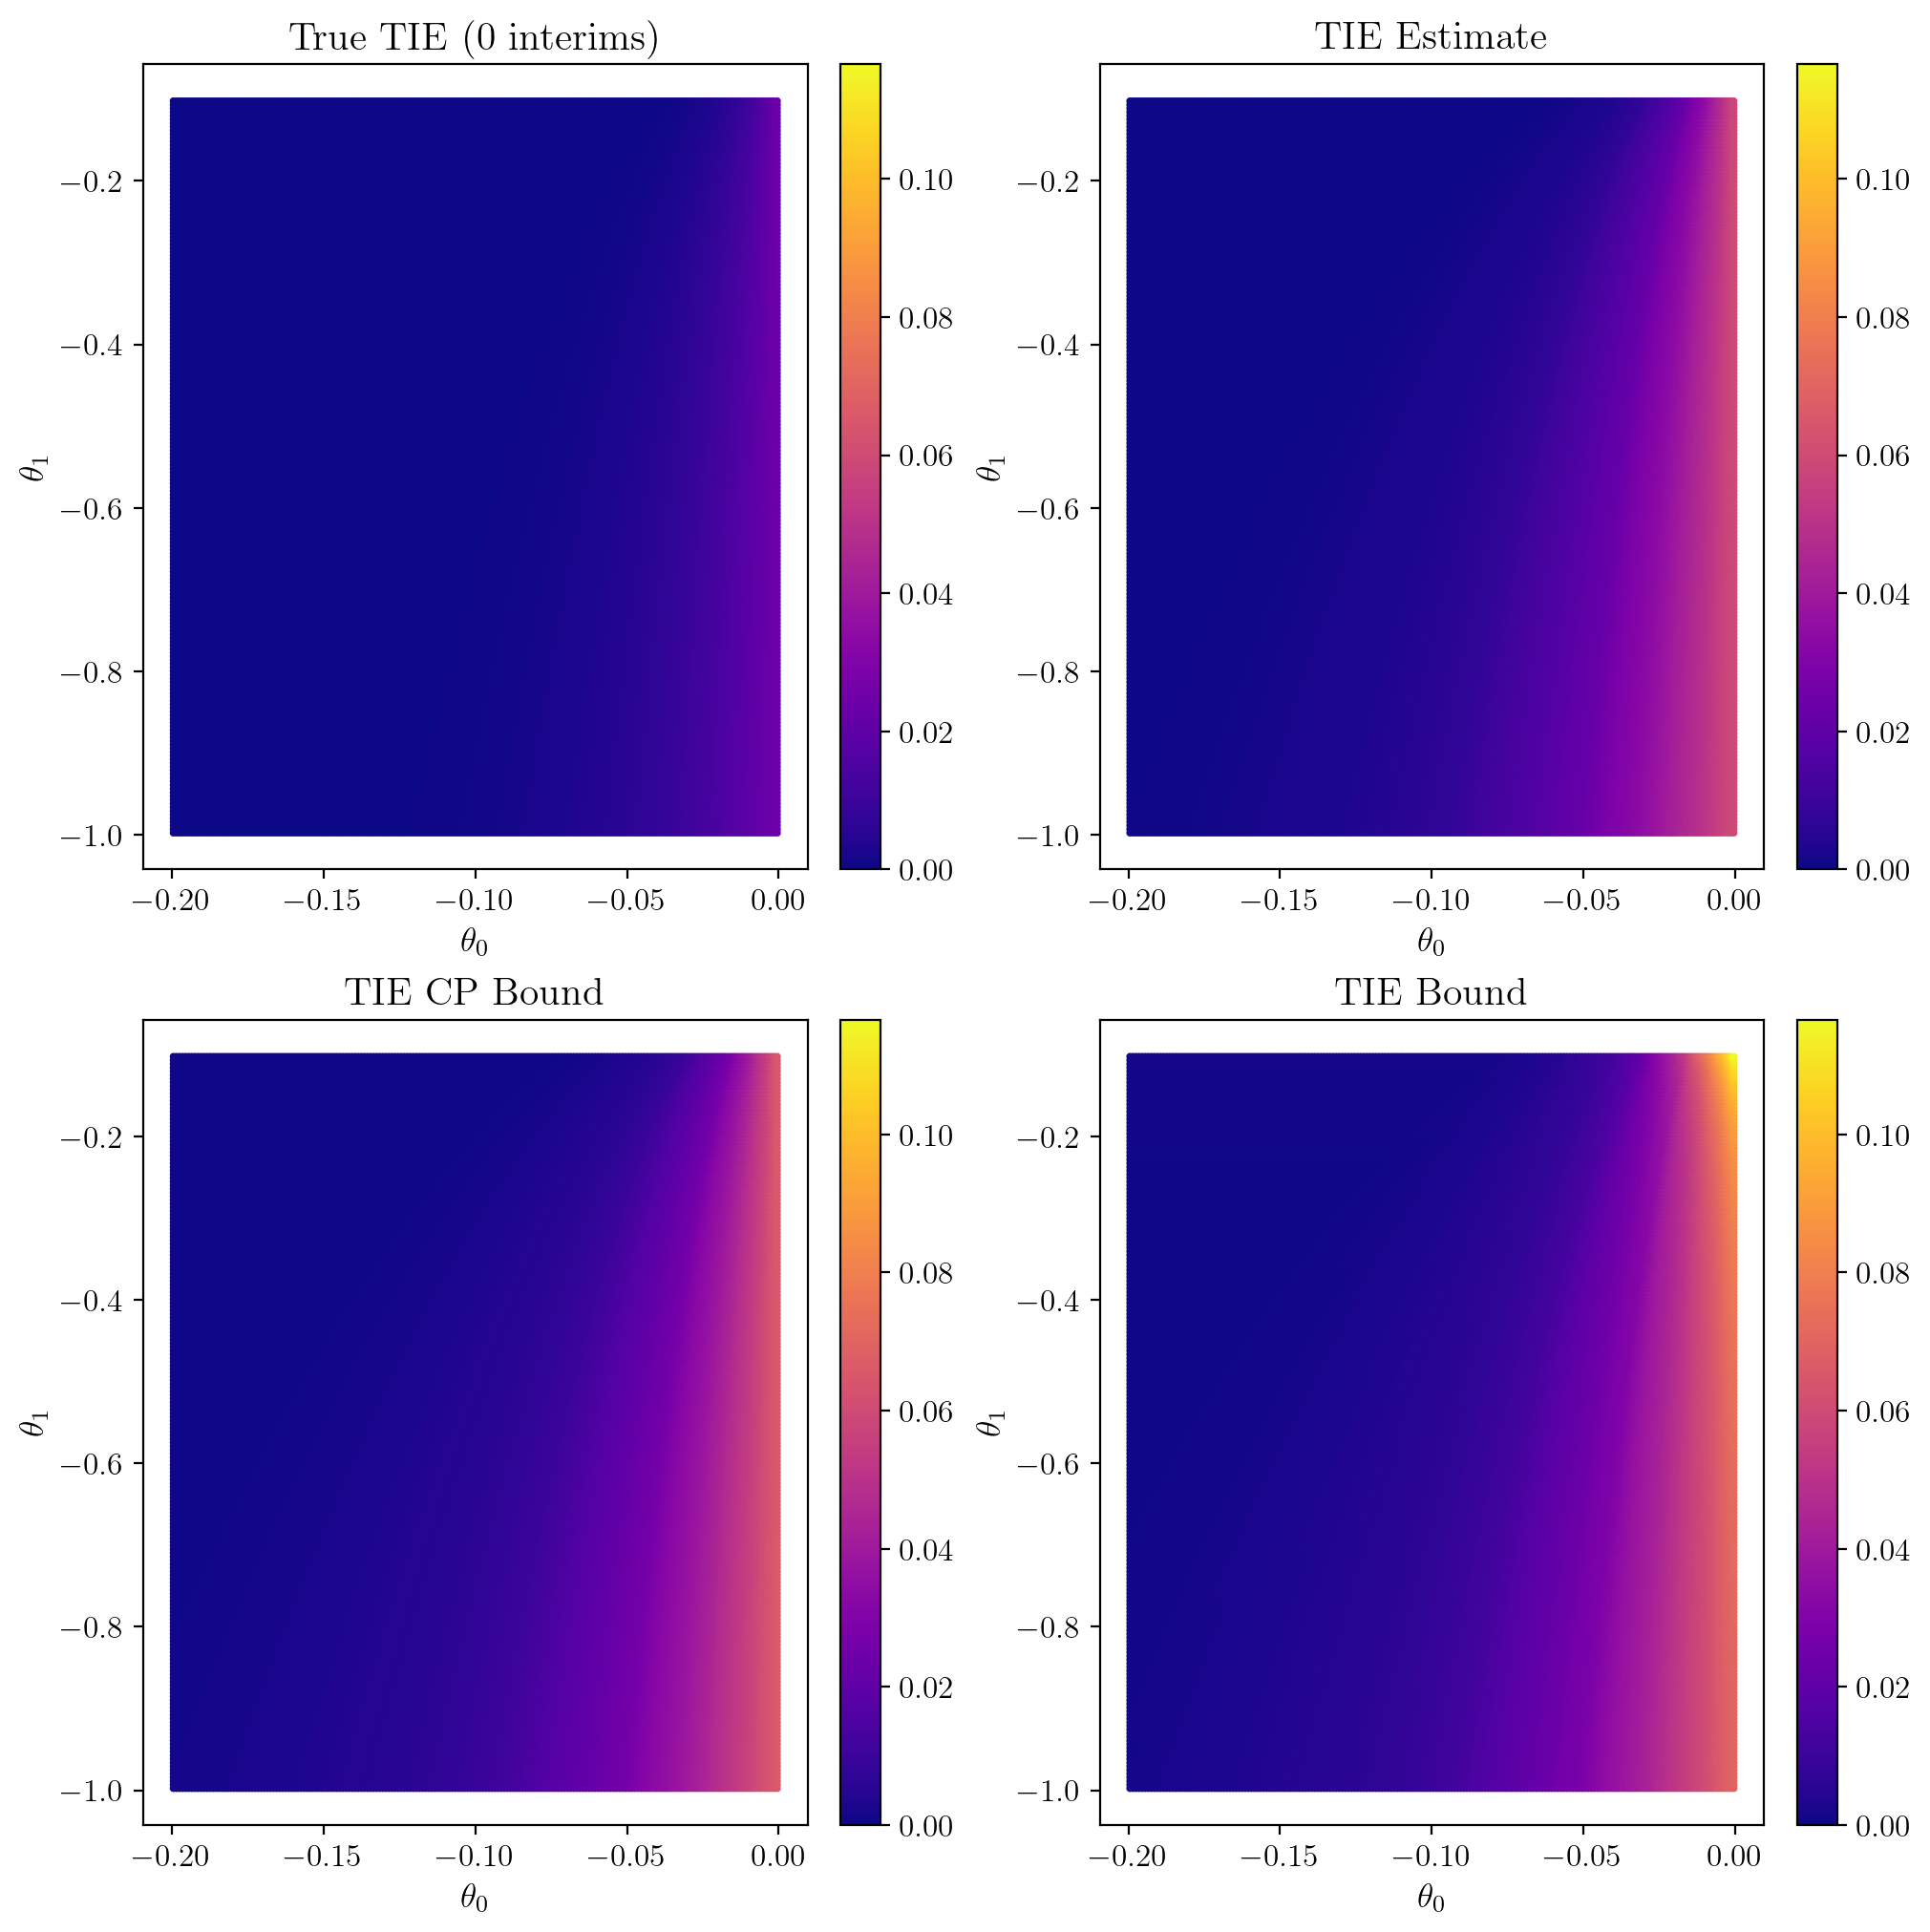

<Figure size 640x480 with 0 Axes>

In [6]:
s = 3
plt.figure(figsize=(10, 10), constrained_layout=True)
names = ["true_tie_no_int", "tie_est", "tie_cp_bound", "tie_bound"]
titles = ["True TIE (0 interims)", "TIE Estimate", "TIE CP Bound", "TIE Bound"]
vmax = rej_df[names].max().max()
for i, (name, title) in enumerate(zip(names, titles)):
    plt.subplot(2, 2, i + 1)
    plt.title(title)
    plt.scatter(
        grid.df["theta0"], grid.df["theta1"], c=rej_df[name], s=s, vmin=0, vmax=vmax
    )
    plt.colorbar()
    plt.xlabel(r"$\theta_0$")
    plt.ylabel(r"$\theta_1$")

plt.show()
plt.savefig("figures/t_test_adaptive.pdf", bbox_inches="tight")